In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
df = pd.read_csv(f'../data/TSLA/2021-06-01 - 2021-09-01.csv', index_col=0, parse_dates=['time'], dayfirst=True)
df.head()

,time,price
0,2021-06-01 04:00:00+00:00,628.88
1,2021-06-01 04:15:00+00:00,628.39
2,2021-06-01 04:30:00+00:00,628.10
3,2021-06-01 04:45:00+00:00,628.10
4,2021-06-01 05:00:00+00:00,628.77


In [4]:
test_size = 74
train_df = df[:-test_size]
test_df = df[-test_size:]

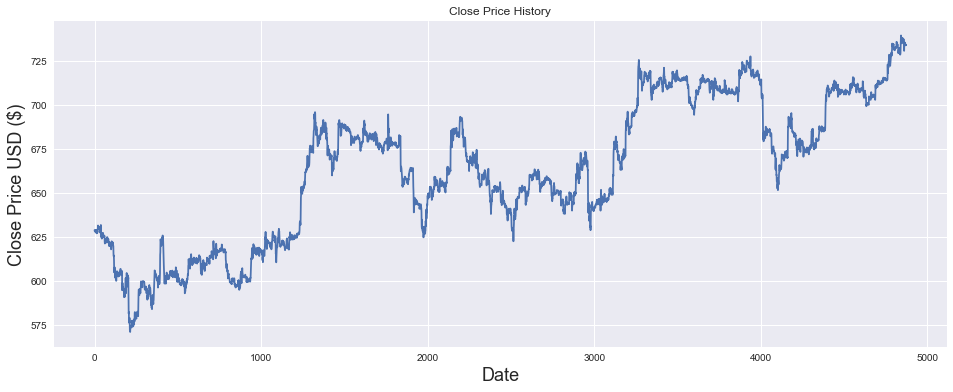

In [5]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['price'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [6]:
data = df.filter(['price'])
dataset = data.values

training_data_len = int(np.ceil(len(dataset) * .95))
training_data_len
type(dataset)

numpy.ndarray

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.34327739],
       [0.34037127],
       [0.33865133],
       ...,
       [0.96969338],
       [0.96838859],
       [0.96803274]])

In [8]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(test_size, len(train_data)):
    x_train.append(train_data[i-test_size: i, 0])
    y_train.append(train_data[i, 0])
    if i <= test_size + 1:
        print(x_train)
        print(y_train)
        print()

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.34327739, 0.34037127, 0.33865133, 0.33865133, 0.34262499,
       0.34161675, 0.34185398, 0.34369254, 0.33764308, 0.34226914,
       0.34392978, 0.33876994, 0.33272048, 0.33455904, 0.33301702,
       0.33740585, 0.34274361, 0.33977819, 0.33616037, 0.34286223,
       0.34991993, 0.35917205, 0.35679972, 0.35602871, 0.35466461,
       0.34944547, 0.35003855, 0.35519839, 0.35122472, 0.34671728,
       0.34814068, 0.34903031, 0.34535318, 0.34570903, 0.3398968 ,
       0.33444042, 0.33805824, 0.3342625 , 0.360892  , 0.35436807,
       0.32032501, 0.33064468, 0.32637447, 0.31682581, 0.31475001,
       0.3174782 , 0.32453591, 0.32269735, 0.32198565, 0.33105984,
       0.33455904, 0.33082261, 0.32210426, 0.32684894, 0.32465453,
       0.32056224, 0.32228219, 0.32044363, 0.32548485, 0.3223415 ,
       0.32340905, 0.30437103, 0.29826226, 0.31451278, 0.31018326,
       0.30810747, 0.30840401, 0.30573513, 0.31077635, 0.31101358,
       0.30828539, 0.30662476, 0.30603167, 0.30247316])]
[0.3

In [9]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
%%time

model.fit(x_train, y_train, batch_size=1, epochs=1)

4557/4557 [==============================] - 65s 14ms/step - loss: 0.0012

In [11]:
test_data = scaled_data[training_data_len - test_size: , :]

x_test = []
y_test = dataset[training_data_len: , :]

for i in range(test_size, len(test_data)):
    x_test.append(test_data[i-test_size: i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2.4151881894279636

In [12]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predicted'] = predictions
valid

C:\Users\spark\AppData\Local\Temp/ipykernel_15936/945455808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicted'] = predictions


,price,Predicted
4631,704.37,708.212524
4632,703.42,707.692139
4633,701.41,707.129578
4634,699.36,706.115479
4635,700.47,704.691284
...,...,...
4869,733.97,735.569763
4870,734.03,735.187317
4871,734.50,734.968628
4872,734.28,735.030579


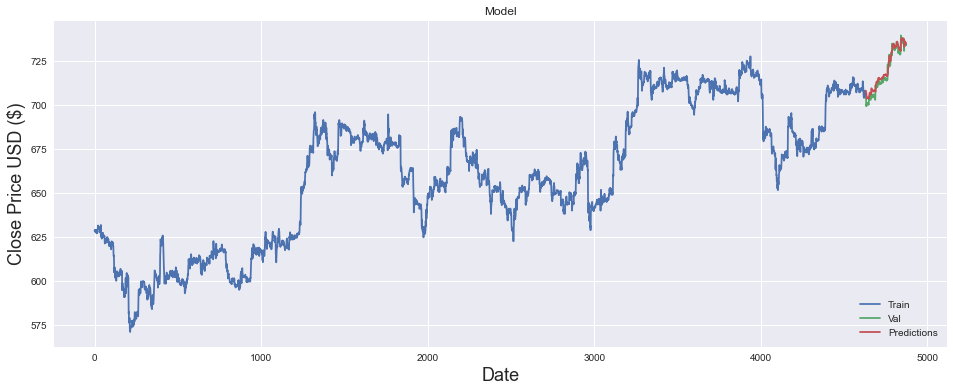

In [13]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['price'])
plt.plot(valid[['price', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [14]:
train = train[4000:]

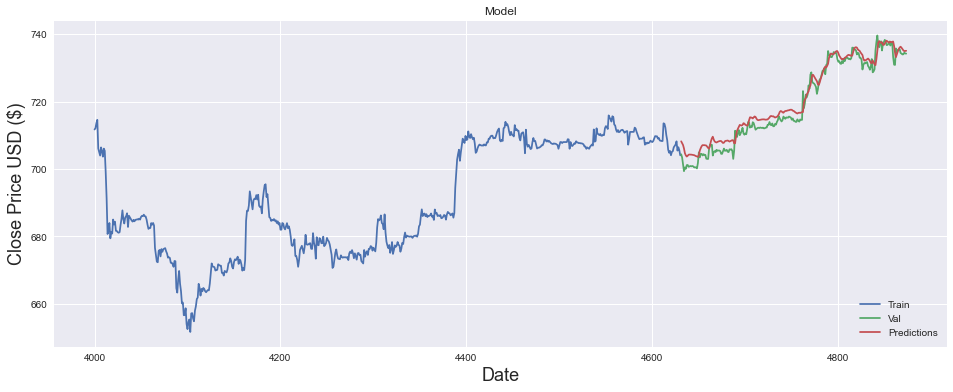

In [15]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['price'])
plt.plot(valid[['price', 'Predicted']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()